In [1]:
import plumed
import matplotlib.pyplot as plt
import numpy as np
import subprocess

In [2]:
# small utility to clean up backup files:
def clean():
    print(subprocess.run("rm -f \#*; rm -fr bck.*",shell=True))

## Exercise 1
In this first exercise we analyze a simulation on the fly

In [7]:
with open("plumed.dat","w") as f:
    print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

hhpsi: HISTOGRAM ARG=psi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

PRINT ARG=phi,psi FILE=colvar.dat STRIDE=100 # use this command to write phi and psi on a file named colvar.dat, every 100 steps
""",file=f)

In [8]:
clean()
subprocess.run("gmx mdrun -plumed plumed.dat -s topolA.tpr -nsteps 200000 -x traj_comp_unbiased.xtc",shell=True)

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)


CompletedProcess(args='gmx mdrun -plumed plumed.dat -s topolA.tpr -nsteps 200000 -x traj_comp_unbiased.xtc', returncode=0)

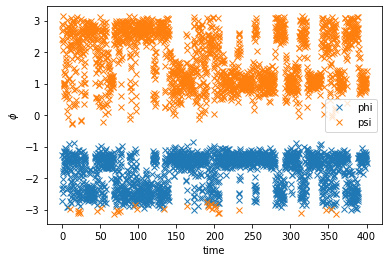

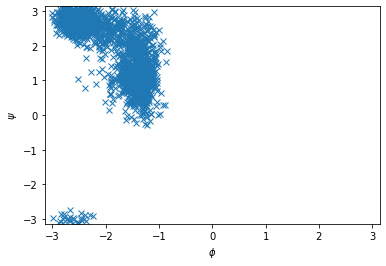

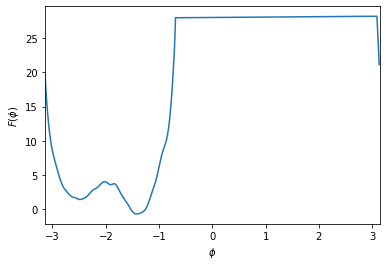

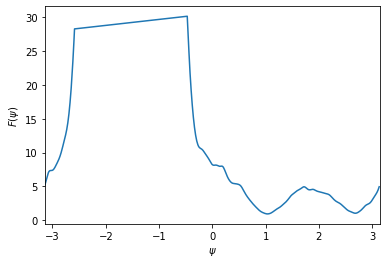

In [9]:
colvar=plumed.read_as_pandas("colvar.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi)
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi)
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- Both psi and phi display many transitions between two minima
- Clearly, the two variables are correlated in that the two metastable states can be equivalently distinguished using phi or using psi

## Exercise 2
We now run a biased MD acting on variable phi

In [6]:
with open("plumed_biased1.dat","w") as f:
    print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2

f: CUSTOM ARG=phi FUNC=-10*sin(x+2) PERIODIC=NO
BIASVALUE ARG=f

lw: REWEIGHT_BIAS

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi_biased1.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

hhpsi: HISTOGRAM ARG=psi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi_biased1.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

# we use a smooth kernel to produce a nicer graph here
hhphir: HISTOGRAM ARG=phi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffphir: CONVERT_TO_FES GRID=hhphir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphir FILE=fes_phi_biased1r.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

hhpsir: HISTOGRAM ARG=psi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffpsir: CONVERT_TO_FES GRID=hhpsir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsir FILE=fes_psi_biased1r.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

PRINT ARG=phi,psi FILE=colvar_biased1.dat STRIDE=100 # use this command to write phi and psi on a file named colvar.dat, every 100 steps
""",file=f)

In [7]:
clean()
subprocess.run("gmx mdrun -plumed plumed_biased1.dat -s topolA.tpr -nsteps 200000 -x traj_comp_biased1.xtc",shell=True)

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)


CompletedProcess(args='gmx mdrun -plumed plumed_biased1.dat -s topolA.tpr -nsteps 200000 -x traj_comp_biased1.xtc', returncode=0)

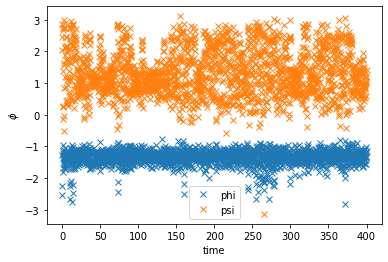

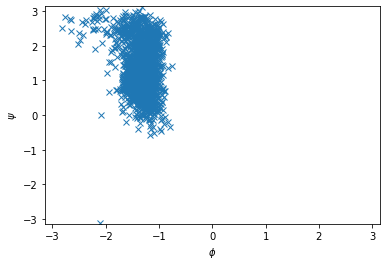

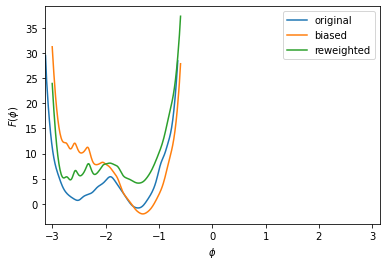

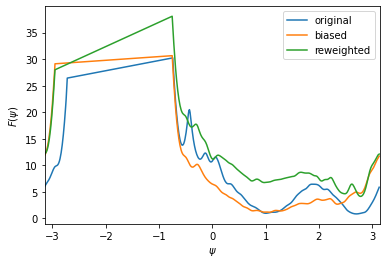

In [8]:
colvar=plumed.read_as_pandas("colvar_biased1.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi,label="original")
fes_phib=plumed.read_as_pandas("fes_phi_biased1.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phib.phi,fes_phib.ffphi,label="biased")
fes_phir=plumed.read_as_pandas("fes_phi_biased1r.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phir.phi,fes_phir.ffphir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi,label="original")
fes_psib=plumed.read_as_pandas("fes_psi_biased1.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psib.psi,fes_psib.ffpsi,label="biased")
fes_psir=plumed.read_as_pandas("fes_psi_biased1r.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psir.psi,fes_psir.ffpsir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- In the biased free energy it seems that minimum at higher phi (lower psi) is more stable
- When "unbiasing" the result the two minima seems more similar.
- The free energy obtained after unbiasing is *not* identical to the one obtained in the original simulation. This is simply because both simulations have been run for a finite number of steps. The results should be consistent within their statistical errors.

## Exercise 3
We will now run a third simulation that is even more biased and then combine the three simulations using binless WHAM.

In [9]:
with open("plumed_biased2.dat","w") as f:
    print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2

f: CUSTOM ARG=phi FUNC=-20*sin(x+2) PERIODIC=NO
BIASVALUE ARG=f

lw: REWEIGHT_BIAS

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi_biased2.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

hhpsi: HISTOGRAM ARG=psi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi_biased2.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

# we use a smooth kernel to produce a nicer graph here
hhphir: HISTOGRAM ARG=phi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffphir: CONVERT_TO_FES GRID=hhphir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphir FILE=fes_phi_biased2r.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

hhpsir: HISTOGRAM ARG=psi STRIDE=100 GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffpsir: CONVERT_TO_FES GRID=hhpsir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsir FILE=fes_psi_biased2r.dat STRIDE=200000 # stride is needed here since PLUMED does not know when the simulation is over

PRINT ARG=phi,psi FILE=colvar_biased2.dat STRIDE=100 # use this command to write phi and psi on a file named colvar.dat, every 100 steps
""",file=f)

In [10]:
subprocess.run("gmx mdrun -plumed plumed_biased2.dat -s topolA.tpr -nsteps 200000 -x traj_comp_biased2.xtc",shell=True)

CompletedProcess(args='gmx mdrun -plumed plumed_biased2.dat -s topolA.tpr -nsteps 200000 -x traj_comp_biased2.xtc', returncode=0)

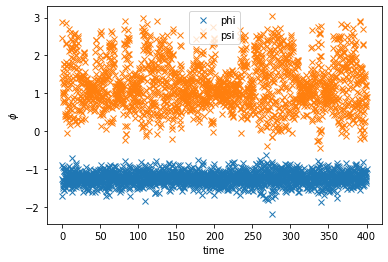

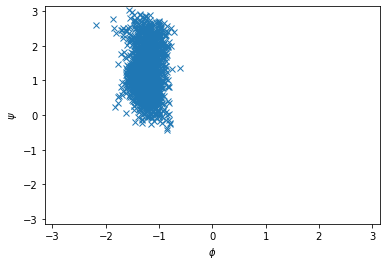

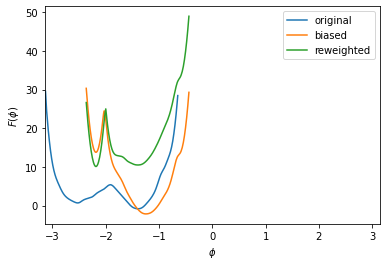

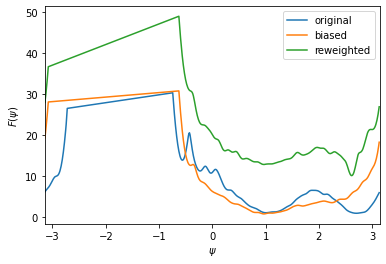

In [11]:
colvar=plumed.read_as_pandas("colvar_biased2.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi,label="original")
fes_phib=plumed.read_as_pandas("fes_phi_biased2.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phib.phi,fes_phib.ffphi,label="biased")
fes_phir=plumed.read_as_pandas("fes_phi_biased2r.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phir.phi,fes_phir.ffphir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi,label="original")
fes_psib=plumed.read_as_pandas("fes_psi_biased2.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psib.psi,fes_psib.ffpsi,label="biased")
fes_psir=plumed.read_as_pandas("fes_psi_biased2r.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psir.psi,fes_psir.ffpsir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- The third simulation is even more biased towards the second minimum
- When "unbiasing" the corresponding profile, we clearly cannot recover the original (blue) profile. However, the correction clearly points in the correct direction, making the stability of the two minima closer
- Also in this case, in principle, the three profile could become identical if the simulations were run for a sufficient time. However, we will always have that the first simulation is more accurate in reproducing the shape of the first minimum, since it spends more time there. The third simulation will always be more accurate in the region with the largest phi values (>-1)

In [12]:
# we now concatenate the trajectories:
subprocess.run("gmx trjcat -cat -f traj_comp_unbiased.xtc traj_comp_biased1.xtc traj_comp_biased2.xtc -o traj_comp_cat.xtc",shell=True)

CompletedProcess(args='gmx trjcat -cat -f traj_comp_unbiased.xtc traj_comp_biased1.xtc traj_comp_biased2.xtc -o traj_comp_cat.xtc', returncode=0)

In [10]:
# then import the wham tool
import wham
print(wham.__file__)

/mnt/c/Users/Salman Bin Kashif/Dropbox/codes/masterclass-21-3/wham.py


In [14]:
# then construct a plumed input file to compute the bias potentials for
# the three potential energy functions along the entire trajectory
with open("plumed_wham.dat","w") as f:
    print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2

# here we list the bias potentials that we used in the three simulations we want to combine
b0: CUSTOM ARG=phi FUNC=0.0 PERIODIC=NO
b1: CUSTOM ARG=phi FUNC=-10*sin(x+2) PERIODIC=NO
b2: CUSTOM ARG=phi FUNC=-20*sin(x+2) PERIODIC=NO
PRINT ARG=phi,psi,b0,b1,b2 FILE=biases.dat
    """,file=f)

In [15]:
subprocess.run("plumed driver --plumed plumed_wham.dat --ixtc traj_comp_cat.xtc",shell=True)

CompletedProcess(args='plumed driver --plumed plumed_wham.dat --ixtc traj_comp_cat.xtc', returncode=0)

In [16]:
bias=plumed.read_as_pandas("biases.dat")
bias

,time,phi,psi,b0,b1,b2
0,0.0,-1.257769,2.877952,0.0,-6.759339,-13.518679
1,1.0,-2.714985,2.432859,0.0,6.556063,13.112125
2,2.0,-2.332921,2.672416,0.0,3.268046,6.536093
3,3.0,-2.010501,2.706560,0.0,0.105006,0.210012
4,4.0,-1.848329,2.401884,0.0,-1.510902,-3.021804
...,...,...,...,...,...,...
5998,5998.0,-1.190224,1.203480,0.0,-7.241328,-14.482656
5999,5999.0,-1.310623,1.208307,0.0,-6.360566,-12.721131
6000,6000.0,-1.110427,0.903936,0.0,-7.768030,-15.536059
6001,6001.0,-1.280298,0.652717,0.0,-6.591606,-13.183212


In [17]:
kBT=300*8.314462618*0.001
w=wham.wham(np.stack((bias.b0,bias.b1,bias.b2)).T,T=kBT)
w

{'logW': array([-1.95670328, -0.15375652, -0.18560698, ..., -2.51453182,
        -1.87192613, -2.92045307]),
 'logZ': array([-0.14209401,  1.68041427,  4.28071719]),
 'nit': 38,
 'eps': 0.0}

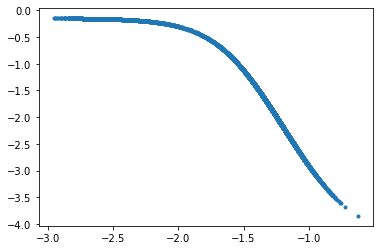

In [18]:
# here we check how the weight depends on the biased CV
plt.plot(bias.phi,w["logW"],".")

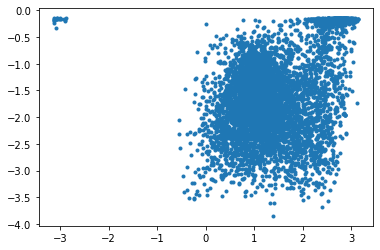

In [19]:
# as a function of psi instead we don't see any feature
plt.plot(bias.psi,w["logW"],".")

In [20]:
# We store the logarithm of the weights as an additional column in the bias dataframe
bias["logweights"]=w["logW"]
bias

,time,phi,psi,b0,b1,b2,logweights
0,0.0,-1.257769,2.877952,0.0,-6.759339,-13.518679,-1.956703
1,1.0,-2.714985,2.432859,0.0,6.556063,13.112125,-0.153757
2,2.0,-2.332921,2.672416,0.0,3.268046,6.536093,-0.185607
3,3.0,-2.010501,2.706560,0.0,0.105006,0.210012,-0.295663
4,4.0,-1.848329,2.401884,0.0,-1.510902,-3.021804,-0.432138
...,...,...,...,...,...,...,...
5998,5998.0,-1.190224,1.203480,0.0,-7.241328,-14.482656,-2.213362
5999,5999.0,-1.310623,1.208307,0.0,-6.360566,-12.721131,-1.759147
6000,6000.0,-1.110427,0.903936,0.0,-7.768030,-15.536059,-2.514532
6001,6001.0,-1.280298,0.652717,0.0,-6.591606,-13.183212,-1.871926


In [21]:
plumed.write_pandas(bias,"bias_wham.dat")

In [22]:
with open("plumed_wham.dat","w") as f:
    print("""
# vim:ft=plumed
phi: READ FILE=bias_wham.dat VALUES=phi
psi: READ FILE=bias_wham.dat VALUES=psi
lw: READ FILE=bias_wham.dat VALUES=logweights

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi_cat.dat

hhpsi: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi_cat.dat

# we use a smooth kernel to produce a nicer graph here
hhphir: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffphir: CONVERT_TO_FES GRID=hhphir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphir FILE=fes_phi_catr.dat

hhpsir: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffpsir: CONVERT_TO_FES GRID=hhpsir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsir FILE=fes_psi_catr.dat

""",file=f)

In [23]:
kb=0.008314462618
T=300
subprocess.run("plumed driver --noatoms --plumed plumed_wham.dat --kt {}".format(kb*T),shell=True)

CompletedProcess(args='plumed driver --noatoms --plumed plumed_wham.dat --kt 2.4943387854', returncode=0)

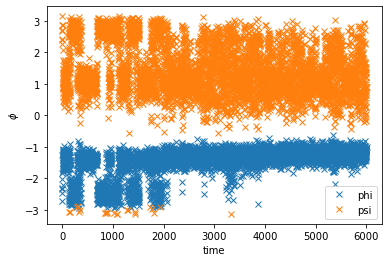

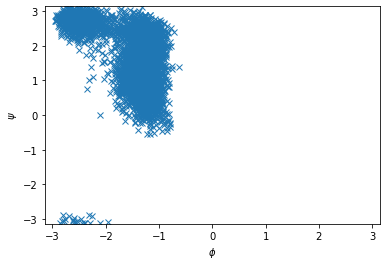

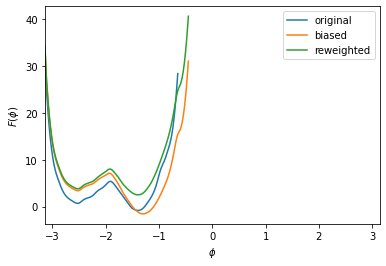

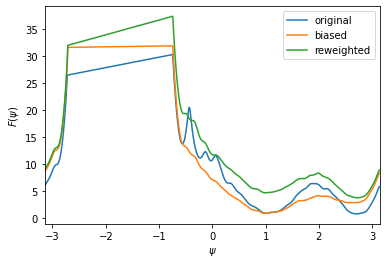

In [24]:
colvar=plumed.read_as_pandas("bias_wham.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi,label="original")
fes_phib=plumed.read_as_pandas("fes_phi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phib.phi,fes_phib.ffphi,label="biased")
fes_phir=plumed.read_as_pandas("fes_phi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phir.phi,fes_phir.ffphir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi,label="original")
fes_psib=plumed.read_as_pandas("fes_psi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psib.psi,fes_psib.ffpsi,label="biased")
fes_psir=plumed.read_as_pandas("fes_psi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psir.psi,fes_psir.ffpsir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- The concatenated trajectory has a clearly visible behavior as a function of time. Earlier times sample both minima, later times mostly sample the higher phi minimum
- The correction (see above) makes sure that the high phi samples are weighted less, so as to result in a correct free-energy profile

## Exercise 4
We will now use the very common multiple-windows protocol. We first generate the windows centers and the corresponding plumed input files

In [25]:
at=np.linspace(-np.pi,np.pi,33)[:-1]
print(at)
for i in range(32):
    with open("plumed_" + str(i) + ".dat","w") as f:
        print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
bb: RESTRAINT ARG=phi KAPPA=200.0 AT={}
PRINT ARG=phi,psi,bb.bias FILE=colvar_multi_{}.dat STRIDE=100
""".format(at[i],i),file=f)

[-3.14159265 -2.94524311 -2.74889357 -2.55254403 -2.35619449 -2.15984495
 -1.96349541 -1.76714587 -1.57079633 -1.37444679 -1.17809725 -0.9817477
 -0.78539816 -0.58904862 -0.39269908 -0.19634954  0.          0.19634954
  0.39269908  0.58904862  0.78539816  0.9817477   1.17809725  1.37444679
  1.57079633  1.76714587  1.96349541  2.15984495  2.35619449  2.55254403
  2.74889357  2.94524311]


In [26]:
# This is to run multiple simulations concurrently.
# Tune max_workers depending on how many processors you have.
# We here use deffnm so as to store separate log files as well, though it is not really necessary
import concurrent.futures
clean()
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # technical note: each "submission" involves a separate "thread"
    # however, the thread is then using subprocess.run to start a new "process"
    # thus, the resulting simulations are run an truly separate processes
    for i in range(32):
        print("submitting",i)
        executor.submit(subprocess.run,"gmx mdrun -deffnm run{} -plumed plumed_{}.dat -s topolA.tpr -nsteps 200000 -x traj_comp_{}.xtc".format(i,i,i),shell=True)

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)
submitting 0
submitting 1
submitting 2
submitting 3
submitting 4
submitting 5
submitting 6
submitting 7
submitting 8
submitting 9
submitting 10
submitting 11
submitting 12
submitting 13
submitting 14
submitting 15
submitting 16
submitting 17
submitting 18
submitting 19
submitting 20
submitting 21
submitting 22
submitting 23
submitting 24
submitting 25
submitting 26
submitting 27
submitting 28
submitting 29
submitting 30
submitting 31


In [27]:
# now concatenate the trajectories:
subprocess.run("gmx_mpi trjcat -cat -f traj_comp_[0-9].xtc traj_comp_[0-9][0-9].xtc -o traj_multi_cat.xtc",shell=True)

CompletedProcess(args='gmx_mpi trjcat -cat -f traj_comp_[0-9].xtc traj_comp_[0-9][0-9].xtc -o traj_multi_cat.xtc', returncode=0)

In [28]:
# and analyze all of them.
# we are here using the same input files we used to run the simulations
# by using the --trajectory-stride option we really mimick what happened in the biased simulations
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    for i in range(32):
        executor.submit(subprocess.run,"plumed driver --plumed plumed_{}.dat --ixtc traj_multi_cat.xtc --trajectory-stride 100".format(i),shell=True)

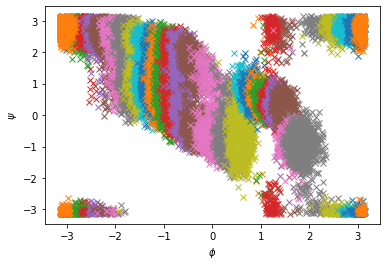

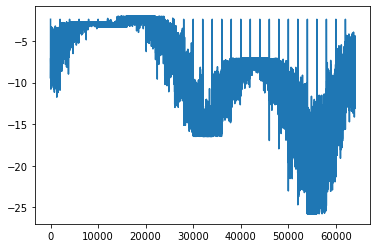

In [29]:
col=[]
for i in range(32):
    col.append(plumed.read_as_pandas("colvar_multi_" + str(i)+".dat"))
# notice that this is the concatenation of 32 trajectories with 2001 frames each
    plt.plot(col[i].phi[2001*i:2001*(i+1)],col[i].psi[2001*i:2001*(i+1)],"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.show()
# in this graph you can appreciate which region was sampled by each simulation
 
bias=np.zeros((len(col[0]["bb.bias"]),32))
for i in range(32):
    bias[:,i]=col[i]["bb.bias"][-len(bias):]
w=wham.wham(bias,T=kBT)
plt.plot(w["logW"])
plt.show()

In [30]:
# we now produce a file to be read by plumed
colvar=col[0]
colvar["logweights"]=w["logW"]
plumed.write_pandas(colvar,"bias_multi.dat")

In [31]:
# and analyze it as we did before
with open("plumed_multi.dat","w") as f:
    print("""
# vim:ft=plumed
phi: READ FILE=bias_multi.dat VALUES=phi IGNORE_TIME
psi: READ FILE=bias_multi.dat VALUES=psi IGNORE_TIME
lw: READ FILE=bias_multi.dat VALUES=logweights IGNORE_TIME

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi_cat.dat

hhpsi: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi_cat.dat

# we use a smooth kernel to produce a nicer graph here
hhphir: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffphir: CONVERT_TO_FES GRID=hhphir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphir FILE=fes_phi_catr.dat

hhpsir: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffpsir: CONVERT_TO_FES GRID=hhpsir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsir FILE=fes_psi_catr.dat

""",file=f)
    

In [32]:
subprocess.run("plumed driver --noatoms --plumed plumed_multi.dat --kt {}".format(kb*T),shell=True)

CompletedProcess(args='plumed driver --noatoms --plumed plumed_multi.dat --kt 2.4943387854', returncode=0)

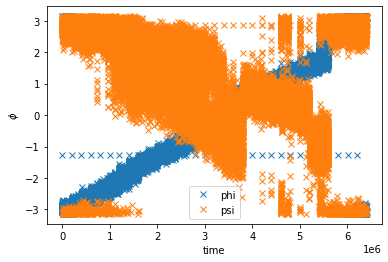

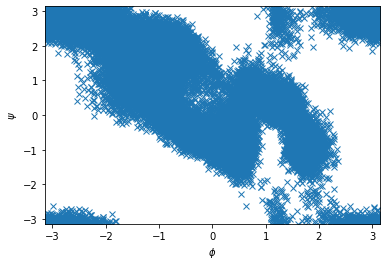

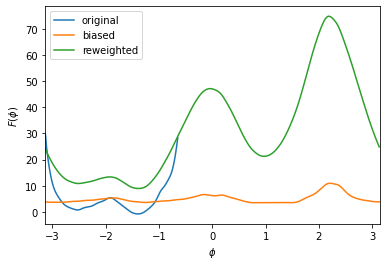

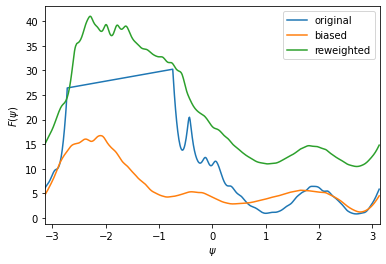

In [33]:
colvar=plumed.read_as_pandas("bias_multi.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi,label="original")
fes_phib=plumed.read_as_pandas("fes_phi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phib.phi,fes_phib.ffphi,label="biased")
fes_phir=plumed.read_as_pandas("fes_phi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phir.phi,fes_phir.ffphir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi,label="original")
fes_psib=plumed.read_as_pandas("fes_psi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psib.psi,fes_psib.ffpsi,label="biased")
fes_psir=plumed.read_as_pandas("fes_psi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psir.psi,fes_psir.ffpsir,label="reweighted")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- The profile along phi now includes another minimum (phi~1). It was only possible to reach it thanks to the restraints.
- Variable psi is not able to distingush this third minimum from the previous ones. The free energy wrt psi can be anyway computed by reweighting

## Exercise 5
We will now compute some additional observables and the associated statistical errors.

In [34]:
# number of blocks
NB=10
# we reshape the bias so that it appears as NB times frames of each traj times number of biases
bb=bias.reshape((32,-1,32))[:,-2000:,:].reshape((32,NB,2000//NB,32))
# we reshape the trajectory so that it appears as NB times frames of each traj times number of biases
cc=np.array(col[0].phi).reshape((32,-1))[:,-2000:].reshape((32,NB,2000//NB))
 
# we first analyse the complete trajectory:
tr=cc.flatten()
is_in_B=np.int_(np.logical_and(tr>0,tr<2))
is_in_A=np.int_(tr<0)
w0=wham.wham(bb.reshape((-1,32)),T=kBT)
 
print("population:",np.average(is_in_B,weights=np.exp(w0["logW"])))
print("Delta F:",-kBT*np.log(
    np.average(is_in_B,weights=np.exp(w0["logW"]))/np.average(is_in_A,weights=np.exp(w0["logW"]))
    )
)
sin_A=np.average(np.sin(tr),weights=np.exp(w0["logW"])*is_in_A)
cos_A=np.average(np.cos(tr),weights=np.exp(w0["logW"])*is_in_A)
sin_B=np.average(np.sin(tr),weights=np.exp(w0["logW"])*is_in_B)
cos_B=np.average(np.cos(tr),weights=np.exp(w0["logW"])*is_in_B)

print("<phi>_A:",np.arctan2(sin_A,cos_A))
print("<phi>_B:",np.arctan2(sin_B,cos_B))

pop=[]
deltaF=[]
phi_A=[]
phi_B=[]
for i in range(200):
    # we then analyze the bootstrapped trajectories
    print(i)
    c=np.random.choice(NB,NB)
    w=wham.wham(bb[:,c,:,:].reshape((-1,32)),T=kBT)
    tr=cc[:,c,:].flatten()
    is_in_B=np.int_(np.logical_and(tr>0,tr<2))
    sin_A=np.average(np.sin(tr),weights=np.exp(w["logW"])*is_in_A)
    cos_A=np.average(np.cos(tr),weights=np.exp(w["logW"])*is_in_A)
    sin_B=np.average(np.sin(tr),weights=np.exp(w["logW"])*is_in_B)
    cos_B=np.average(np.cos(tr),weights=np.exp(w["logW"])*is_in_B)
    pop.append(np.average(is_in_B,weights=np.exp(w["logW"])))
    deltaF.append(-kBT*np.log(
        np.average(is_in_B,weights=np.exp(w["logW"]))/np.average(is_in_A,weights=np.exp(w["logW"]))
    ))
    phi_A.append(np.arctan2(sin_A,cos_A))
    phi_B.append(np.arctan2(sin_B,cos_B))

population: 0.004030610887883766
Delta F: 13.743092739246205
<phi>_A: -1.8209412218430616
<phi>_B: 0.9744143352532965
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [35]:
print("error population:",np.std(pop))
print("error Delta F:",np.std(deltaF))
print("error <phi>_A:",np.std(phi_A))
print("error <phi>_B:",np.std(phi_B))

error population: 0.0005904911846041497
error Delta F: 0.3647956161155046
error <phi>_A: 0.06008873829466503
error <phi>_B: 0.0017286037872935478


Comments:
- We are here analyzing the full trajectories. **It is common practice to discard the initial part of the trajectory**.
- Be careful when computing average angles! In this case periodicity is fine (by chance), but in general the approach of using circular averages (average sin and cos followed by arctan2) is much safer (https://en.wikipedia.org/wiki/Mean_of_circular_quantities)
- Bootstrap can be slow if you re-perform wham every time. The provided wham script could be optimized e.g.:
    - Starting from the w0 logZ instead of starting from scratch at every iteration
    - Converting the self-consistent procedure to a minimization (see Tan, Gallicchio, Lapelosa, and Levy et al JCTC 2012)
- Computing log(PA/PB) might lead to infinities when doing bootstrap. A more robust alternative is to use Bayesian bootstrap. See e.g. Hub et al, JCTC 2010.

## Exercise 6
We will now repeat exercise 4 but using a starting from the other minimum.

In [36]:
at=np.linspace(-np.pi,np.pi,33)[:-1]
print(at)
for i in range(32):
    with open("plumed_" + str(i) + ".dat","w") as f:
        print("""
# vim:ft=plumed
MOLINFO STRUCTURE=reference.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
bb: RESTRAINT ARG=phi KAPPA=200.0 AT={}
PRINT ARG=phi,psi,bb.bias FILE=colvar_multi_B_{}.dat STRIDE=100
""".format(at[i],i),file=f)

[-3.14159265 -2.94524311 -2.74889357 -2.55254403 -2.35619449 -2.15984495
 -1.96349541 -1.76714587 -1.57079633 -1.37444679 -1.17809725 -0.9817477
 -0.78539816 -0.58904862 -0.39269908 -0.19634954  0.          0.19634954
  0.39269908  0.58904862  0.78539816  0.9817477   1.17809725  1.37444679
  1.57079633  1.76714587  1.96349541  2.15984495  2.35619449  2.55254403
  2.74889357  2.94524311]


In [37]:
# This is to run multiple simulations concurrently.
# Tune max_workers depending on how many processors you have.
# We here use deffnm so as to store separate log files as well, though it is not really necessary
import concurrent.futures
clean()
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # technical note: each "submission" involves a separate "thread"
    # however, the thread is then using subprocess.run to start a new "process"
    # thus, the resulting simulations are run an truly separate processes
    for i in range(32):
        print("submitting",i)
        executor.submit(subprocess.run,"gmx mdrun -deffnm run{} -plumed plumed_{}.dat -s topolB.tpr -nsteps 200000 -x traj_comp_B_{}.xtc".format(i,i,i),shell=True)

CompletedProcess(args='rm -f \\#*; rm -fr bck.*', returncode=0)
submitting 0
submitting 1
submitting 2
submitting 3
submitting 4
submitting 5
submitting 6
submitting 7
submitting 8
submitting 9
submitting 10
submitting 11
submitting 12
submitting 13
submitting 14
submitting 15
submitting 16
submitting 17
submitting 18
submitting 19
submitting 20
submitting 21
submitting 22
submitting 23
submitting 24
submitting 25
submitting 26
submitting 27
submitting 28
submitting 29
submitting 30
submitting 31


In [38]:
# now concatenate the trajectories:
subprocess.run("gmx_mpi trjcat -cat -f traj_comp_B_[0-9].xtc traj_comp_B_[0-9][0-9].xtc -o traj_multi_B_cat.xtc",shell=True)

CompletedProcess(args='gmx_mpi trjcat -cat -f traj_comp_B_[0-9].xtc traj_comp_B_[0-9][0-9].xtc -o traj_multi_B_cat.xtc', returncode=0)

In [39]:
# and analyze all of them.
# we are here using the same input files we used to run the simulations
# by using the --trajectory-stride option we really mimick what happened in the biased simulations
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    for i in range(32):
        executor.submit(subprocess.run,"plumed driver --plumed plumed_{}.dat --ixtc traj_multi_B_cat.xtc --trajectory-stride 100".format(i),shell=True)

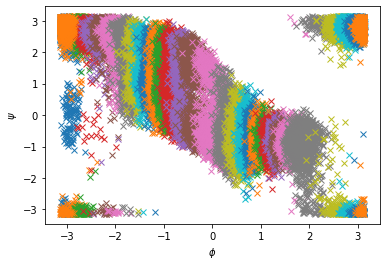

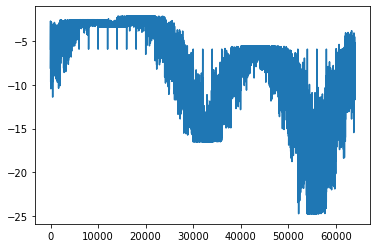

In [40]:
col=[]
for i in range(32):
    col.append(plumed.read_as_pandas("colvar_multi_B_" + str(i)+".dat"))
# notice that this is the concatenation of 32 trajectories with 2001 frames each
    plt.plot(col[i].phi[2001*i:2001*(i+1)],col[i].psi[2001*i:2001*(i+1)],"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.show()
# in this graph you can appreciate which region was sampled by each simulation
 
bias=np.zeros((len(col[0]["bb.bias"]),32))
for i in range(32):
    bias[:,i]=col[i]["bb.bias"][-len(bias):]
w=wham.wham(bias,T=kBT)
plt.plot(w["logW"])
plt.show()
colvar=col[0]
colvar["logweights"]=w["logW"]
plumed.write_pandas(colvar,"bias_multi_B.dat")

In [41]:
# and analyze it as we did before
with open("plumed_multi_B.dat","w") as f:
    print("""
# vim:ft=plumed
phi: READ FILE=bias_multi_B.dat VALUES=phi IGNORE_TIME
psi: READ FILE=bias_multi_B.dat VALUES=psi IGNORE_TIME
lw: READ FILE=bias_multi_B.dat VALUES=logweights IGNORE_TIME

# use the command below to compute the histogram of phi
# we use a smooth kernel to produce a nicer graph here
hhphi: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffphi: CONVERT_TO_FES GRID=hhphi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphi FILE=fes_phi_B_cat.dat

hhpsi: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05
ffpsi: CONVERT_TO_FES GRID=hhpsi # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsi FILE=fes_psi_B_cat.dat

# we use a smooth kernel to produce a nicer graph here
hhphir: HISTOGRAM ARG=phi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffphir: CONVERT_TO_FES GRID=hhphir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffphir FILE=fes_phi_B_catr.dat

hhpsir: HISTOGRAM ARG=psi GRID_MIN=-pi GRID_MAX=pi GRID_BIN=600 BANDWIDTH=0.05 LOGWEIGHTS=lw
ffpsir: CONVERT_TO_FES GRID=hhpsir # no need to set TEMP here, PLUMED will obtain it from GROMACS
DUMPGRID GRID=ffpsir FILE=fes_psi_B_catr.dat

""",file=f)
    

In [42]:
subprocess.run("plumed driver --noatoms --plumed plumed_multi_B.dat --kt {}".format(kb*T),shell=True)

CompletedProcess(args='plumed driver --noatoms --plumed plumed_multi_B.dat --kt 2.4943387854', returncode=0)

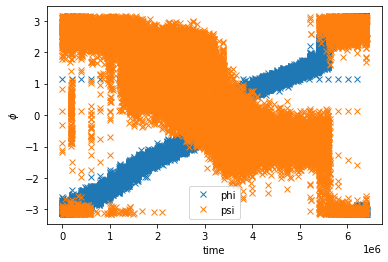

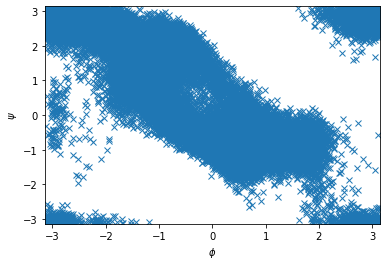

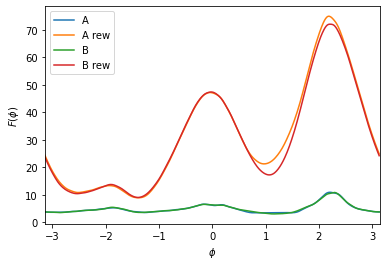

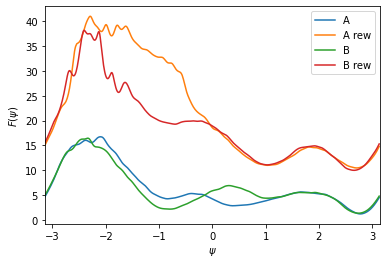

In [43]:
colvar=plumed.read_as_pandas("bias_multi_B.dat")
plt.plot(colvar.time,colvar.phi,"x",label="phi")
plt.plot(colvar.time,colvar.psi,"x",label="psi")
plt.xlabel("time")
plt.ylabel("$\phi$")
plt.legend()
plt.show()

plt.plot(colvar.phi,colvar.psi,"x")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi,np.pi))
plt.show()

fes_phi=plumed.read_as_pandas("fes_phi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphi,label="A")
fes_phi=plumed.read_as_pandas("fes_phi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phi.phi,fes_phi.ffphir,label="A rew")
fes_phib=plumed.read_as_pandas("fes_phi_B_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phib.phi,fes_phib.ffphi,label="B")
fes_phir=plumed.read_as_pandas("fes_phi_B_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_phir.phi,fes_phir.ffphir,label="B rew")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$F(\phi)$")
plt.show()

fes_psi=plumed.read_as_pandas("fes_psi_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsi,label="A")
fes_psi=plumed.read_as_pandas("fes_psi_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psi.psi,fes_psi.ffpsir,label="A rew")
fes_psib=plumed.read_as_pandas("fes_psi_B_cat.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psib.psi,fes_psib.ffpsi,label="B")
fes_psir=plumed.read_as_pandas("fes_psi_B_catr.dat").replace([np.inf, -np.inf], np.nan).dropna()
plt.plot(fes_psir.psi,fes_psir.ffpsir,label="B rew")
plt.legend()
plt.xlim((-np.pi,np.pi))
plt.xlabel("$\psi$")
plt.ylabel("$F(\psi)$")
plt.show()

Comments:
- The distributions are very similar and in A and B simulations. Indeed, in both cases we forced them to be as flat as possible
- The reweighted profiles are *not* identical!
- In the region at negative phi they are undistinguishable. Indeed, the transitions between the two minima are fast, and there is no reason to expect a different relative stability
- The difference between the minimum at negative phi and at positive phi is different. In particular, if starting in B, the minimum in B seems more stable. This is a general rule (based on experience of who is writing...)
- The difference between two different initialization protocols might be larger than the statistical error estimated by bootstrap! The difference actually would probably be smaller if one were discarding the initial part of the trajectory.

## Extra checks

We here re-perfrom some of the analysis **discarding** the initial part of the trajectory. We first define a function that prints the free-energy difference between the two minima only keeping a given number of frames.

In [77]:
def analyze_keeping_last(keep_last):
    col=[]
    for i in range(32):
        col.append(plumed.read_as_pandas("colvar_multi_" + str(i)+".dat"))
    bias=np.zeros((len(col[0]["bb.bias"]),32))
    for i in range(32):
        bias[:,i]=col[i]["bb.bias"][:]
    tr=col[i]["phi"]

    # discard initial part of each simulation

    bias=bias.reshape((32,-1,32))[:,-keep_last:,:].reshape((-1,32))
    tr=np.array(tr).reshape((32,-1))[:,-keep_last:].flatten()
    print(bias.shape,tr.shape)
    w=wham.wham(bias,T=kBT)
    print(-kBT*np.log(np.sum(np.exp(w["logW"])*(np.logical_and(tr>0,tr<2)))/np.sum(np.exp(w["logW"])*(tr<0.0))))

    col=[]
    for i in range(32):
        col.append(plumed.read_as_pandas("colvar_multi_B_" + str(i)+".dat"))
    bias=np.zeros((len(col[0]["bb.bias"]),32))
    for i in range(32):
        bias[:,i]=col[i]["bb.bias"][:]
    tr=col[i]["phi"]

    # discard initial part of each simulation

    bias=bias.reshape((32,-1,32))[:,-keep_last:,:].reshape((-1,32))
    tr=np.array(tr).reshape((32,-1))[:,-keep_last:].flatten()
    print(bias.shape,tr.shape)
    w=wham.wham(bias,T=kBT)
    print(-kBT*np.log(np.sum(np.exp(w["logW"])*(np.logical_and(tr>0,tr<2)))/np.sum(np.exp(w["logW"])*(tr<0.0))))

In [78]:
analyze_keeping_last(2000)

(64000, 32) (64000,)
13.743092739246203
(64000, 32) (64000,)
10.83535849790884


In [79]:
analyze_keeping_last(1000)

(32000, 32) (32000,)
12.995824422699005
(32000, 32) (32000,)
11.296825505043174


As you can see, results are getting closer. However, the difference between the two estimates of Delta F is still quite large.